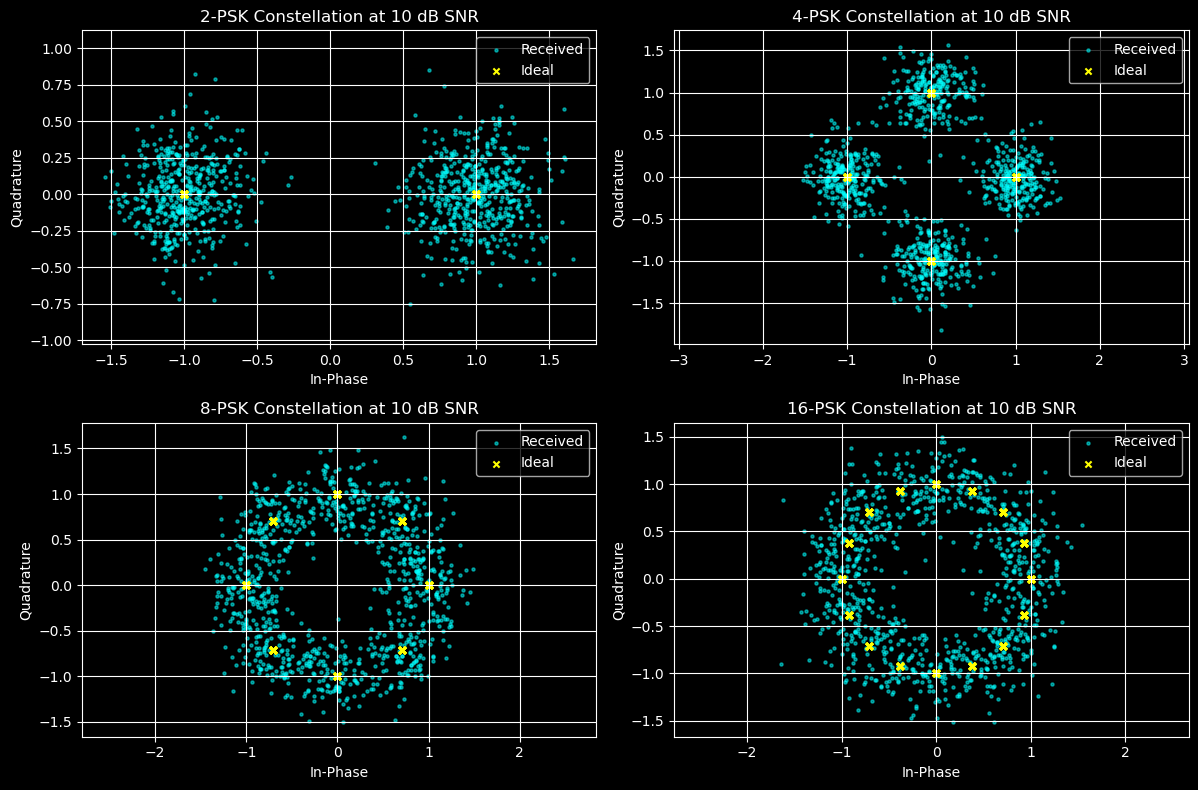

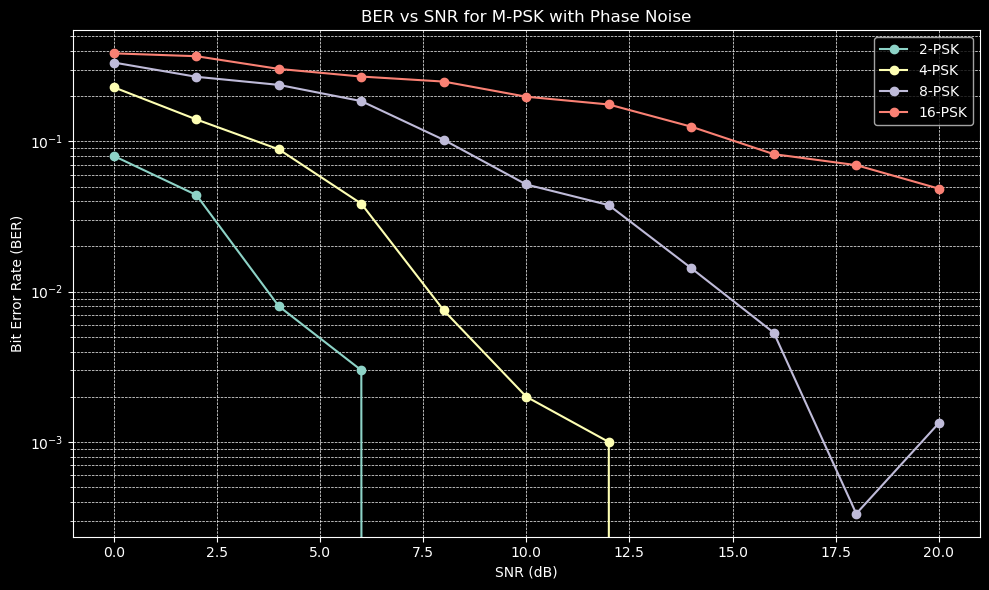

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def mpsk_modulate(bits, M):
    k = int(np.log2(M))
    symbols = bits.reshape((-1, k))
    dec = symbols.dot(1 << np.arange(k)[::-1])
    theta = 2 * np.pi * dec / M
    return np.exp(1j * theta)

def mpsk_demodulate(received, M):
    angles = np.angle(received) % (2 * np.pi)
    decisions = np.round(angles / (2 * np.pi / M)) % M
    decisions = decisions.astype(int)
    k = int(np.log2(M))
    bits_out = ((decisions[:, None] & (1 << np.arange(k)[::-1])) > 0).astype(int)
    return bits_out.reshape(-1)

def add_awgn(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_power = 1 / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
    return signal + noise

def add_phase_noise(signal, phase_noise_std):
    phase_noise = np.random.normal(0, phase_noise_std, len(signal))
    noisy_signal = signal * np.exp(1j * phase_noise)
    return noisy_signal

M_values = [2, 4, 8, 16]
num_symbols = 1000
snr_range = np.arange(0, 21, 2)
phase_noise_std = 0.1

plt.style.use('dark_background')

# Plot Constellations at a fixed SNR (e.g. 10 dB)
plt.figure(figsize=(12, 8))
snr_constellation = 10

for i, M in enumerate(M_values, 1):
    k = int(np.log2(M))
    bits = np.random.randint(0, 2, num_symbols * k)
    symbols = mpsk_modulate(bits, M)
    rx = add_awgn(symbols, snr_constellation)
    rx = add_phase_noise(rx, phase_noise_std)

    plt.subplot(2, 2, i)
    plt.scatter(rx.real, rx.imag, color='cyan', s=5, alpha=0.5, label='Received')
    plt.scatter(symbols.real, symbols.imag, color='yellow', s=20, marker='x', label='Ideal')
    plt.title(f'{M}-PSK Constellation at {snr_constellation} dB SNR')
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot BER vs SNR
plt.figure(figsize=(10, 6))

for M in M_values:
    k = int(np.log2(M))
    bits = np.random.randint(0, 2, num_symbols * k)
    ber_list = []

    for snr_db_loop in snr_range:
        symbols = mpsk_modulate(bits, M)
        rx = add_awgn(symbols, snr_db_loop)
        rx = add_phase_noise(rx, phase_noise_std)
        bits_hat = mpsk_demodulate(rx, M)
        ber = np.mean(bits != bits_hat)
        ber_list.append(ber)

    plt.semilogy(snr_range, ber_list, marker='o', label=f'{M}-PSK')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('BER vs SNR for M-PSK with Phase Noise')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.legend()
plt.tight_layout()
plt.show()



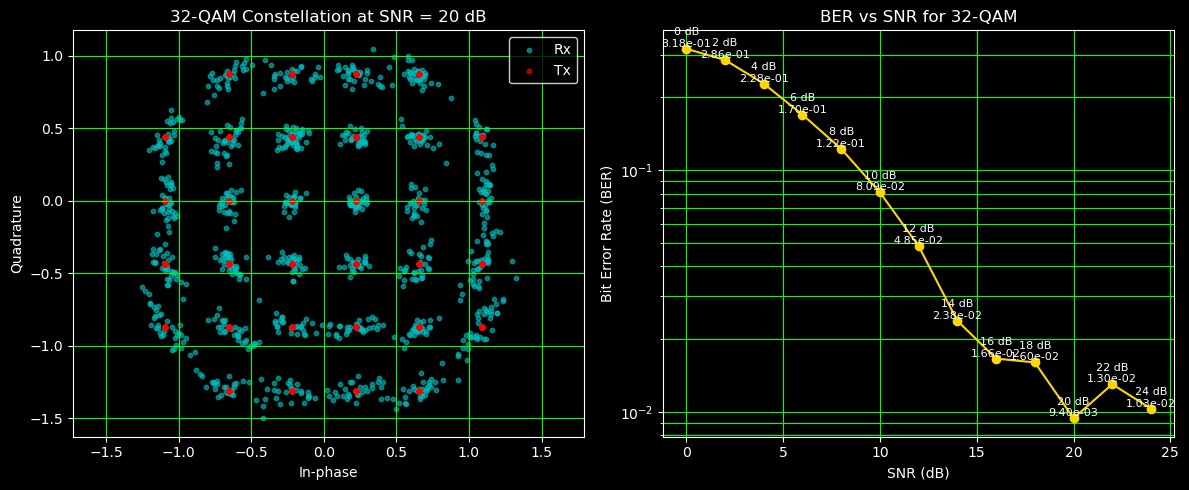

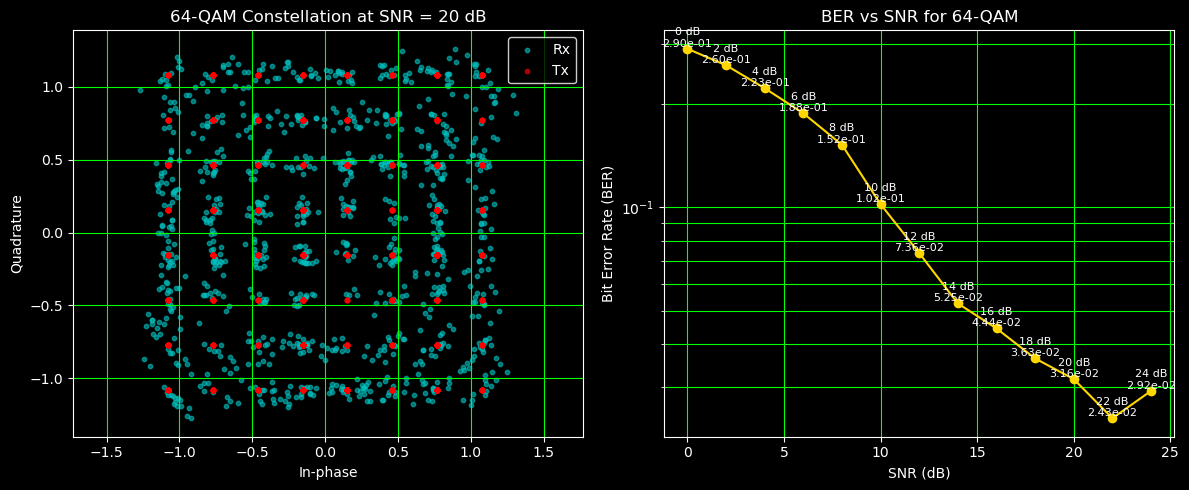

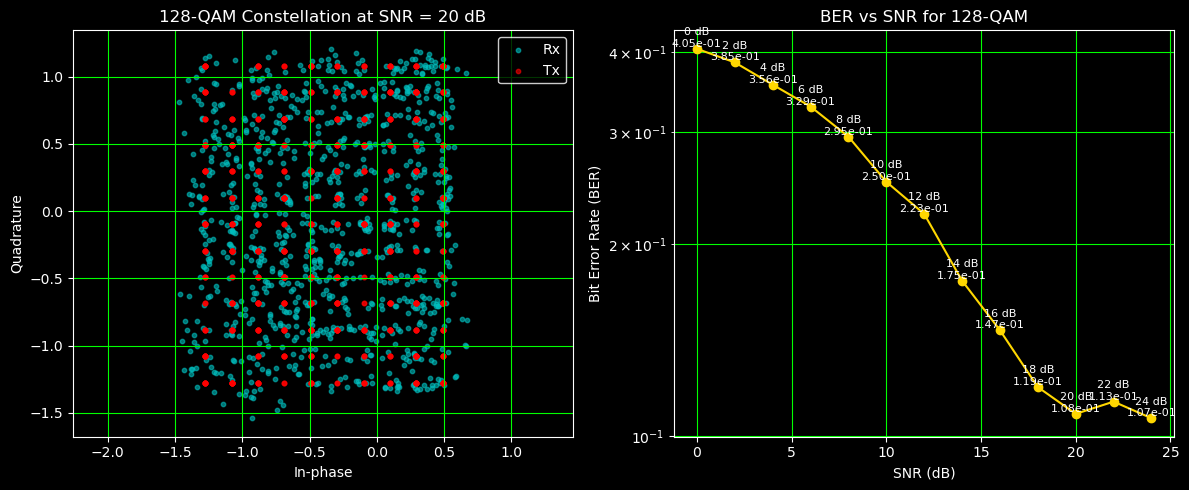

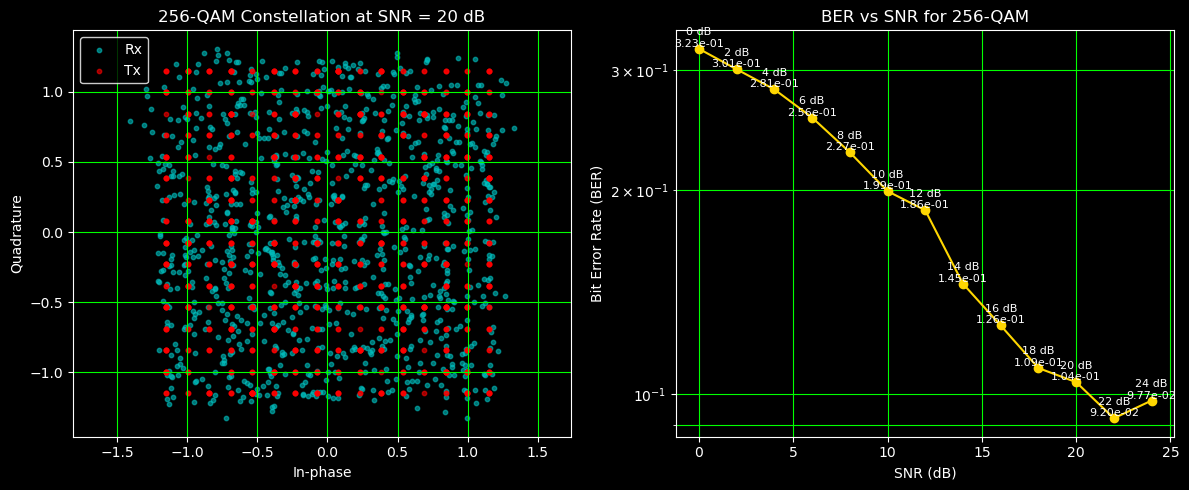

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to generate the QAM constellation
def generate_qam_constellation(M):
    if M == 32:
        const = generate_stacked_32qam()
    elif M == 64:
        m = 8
        I = np.arange(-m + 1, m, 2)
        Q = np.arange(-m + 1, m, 2)
        const = np.array([i + 1j * q for q in Q for i in I])
    elif M == 128:
        const = generate_128qam()
    elif M == 256:
        m = 16
        I = np.arange(-m + 1, m, 2)
        Q = np.arange(-m + 1, m, 2)
        const = np.array([i + 1j * q for q in Q for i in I])
    else:
        raise ValueError("Unsupported M")

    # Normalize constellation
    const /= np.sqrt(np.mean(np.abs(const)**2))

    # Generate bit map for modulation/demodulation
    labels = [np.binary_repr(i, width=int(np.log2(M))) for i in range(M)]
    bit_map = dict(zip(const, labels))

    return const, bit_map

# Custom function for generating 32-QAM constellation
def generate_stacked_32qam():
    constellation = []
    y_offsets = [2.0, 1.0, 0.0, -1.0, -2.0, -3.0]
    points_per_row = [4, 6, 6, 6, 6, 4]

    for row, (y, num_points) in enumerate(zip(y_offsets, points_per_row)):
        if num_points == 6:
            x_positions = np.linspace(-2.5, 2.5, 6)
        else:
            x_positions = np.linspace(-1.5, 1.5, 4)

        for x in x_positions:
            constellation.append(complex(x, y))

    return np.array(constellation)

# Custom function for generating 128-QAM constellation
def generate_128qam():
    constellation = []
    for i in range(-13, 13, 2):
        for j in range(-13, 13, 2):
            if abs(i) == 11 and abs(j) == 11:  # Remove the 4 corner points
                continue
            constellation.append(i + 1j * j)

    return np.array(constellation[:128])

# Function to modulate the bits
def modulate(bits, M, bit_map):
    k = int(np.log2(M))
    symbols = []
    bit_strs = [''.join(str(b) for b in bits[i:i+k]) for i in range(0, len(bits), k)]
    reverse_map = {v: k for k, v in bit_map.items()}
    for b in bit_strs:
        symbols.append(reverse_map[b])
    return np.array(symbols)

# Function to demodulate the received symbols
def demodulate(rx, bit_map):
    symbols = np.array(list(bit_map.keys()))
    labels = list(bit_map.values())
    bits = []
    for r in rx:
        idx = np.argmin(np.abs(symbols - r))
        bits.extend(list(labels[idx]))
    return np.array(bits).astype(int)

# Main simulation function
def simulate_qam(M=256, num_bits=10000, snr_range=np.arange(0, 25, 2), snr_db_ref=20, noise_scale=4):
    k = int(np.log2(M))
    if num_bits % k != 0:
        num_bits += k - (num_bits % k)

    # Generate the QAM constellation and bit map
    constellation, bit_map = generate_qam_constellation(M)

    ber = []
    snr_values = []
    ber_values = []
    tx_symbols_ref, rx_symbols_ref = None, None
    for snr_db in snr_range:
        snr_linear = 10**(snr_db / 10)
        noise_std = np.sqrt(1 / (2 * k * snr_linear))

        # Transmit random bits
        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = modulate(tx_bits, M, bit_map)

        # Add noise with scaling factor
        noise = noise_std * (np.random.randn(len(tx_symbols)) + 1j * np.random.randn(len(tx_symbols)))
        rx_symbols = tx_symbols + noise_scale * 0.3 * noise  # Apply the noise scaling factor--------------

        # Add phase noise (small random phase rotation)
        phase_noise_std = 0.1  # phase noise std dev in radians, adjust as needed------------------------
        phase_noise = np.exp(1j * np.random.randn(len(tx_symbols)) * phase_noise_std)
        rx_symbols = rx_symbols * phase_noise  # apply phase noise multiplicatively

        # Demodulate and calculate BER
        rx_bits = demodulate(rx_symbols, bit_map)
        ber_value = np.sum(rx_bits != tx_bits) / num_bits
        ber.append(ber_value)
        snr_values.append(snr_db)
        ber_values.append(ber_value)

        # Store symbols for plotting
        if snr_db == snr_db_ref:
            tx_symbols_ref = tx_symbols[:1000]
            rx_symbols_ref = rx_symbols[:1000]

    # Plotting
    plt.style.use('dark_background')  # Use dark background globally

    plt.figure(figsize=(12, 5))

    # Constellation plot with dark mode colors
    plt.subplot(1, 2, 1)
    plt.scatter(rx_symbols_ref.real, rx_symbols_ref.imag, alpha=0.6, label='Rx', color='c', s=10)
    plt.scatter(tx_symbols_ref.real, tx_symbols_ref.imag, alpha=0.6, label='Tx', color='red', s=10)
    plt.title(f"{M}-QAM Constellation at SNR = {snr_db_ref} dB", color='white')
    plt.xlabel("In-phase", color='white')
    plt.ylabel("Quadrature", color='white')
    plt.axis('equal')
    plt.grid(True, color='lime')
    plt.legend(facecolor='black', edgecolor='white', labelcolor='white')

    # BER Curve with dark mode colors
    plt.subplot(1, 2, 2)
    plt.semilogy(snr_range, ber, marker='o', color='gold')
    plt.title(f"BER vs SNR for {M}-QAM", color='white')
    plt.xlabel("SNR (dB)", color='white')
    plt.ylabel("Bit Error Rate (BER)", color='white')
    plt.grid(True, which='both', color='lime')

    # Add numerical values of SNR and BER to the plot with bright text
    for i in range(len(snr_values)):
        plt.text(snr_values[i], ber_values[i], f"{snr_values[i]} dB\n{ber_values[i]:.2e}",
                 ha='center', va='bottom', fontsize=8, color='white')

    plt.tight_layout()
    plt.show()
l=[32,64,128,256]
for i in l:
    simulate_qam(i)



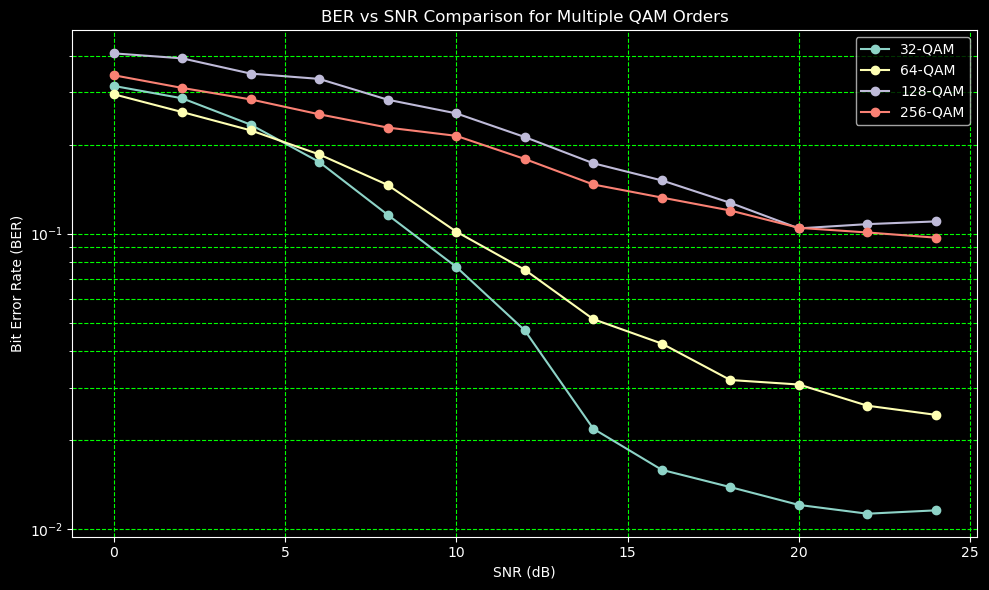

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# (Your constellation generation and modulation/demodulation functions remain unchanged)
# ...

def simulate_qam(M=256, num_bits=10000, snr_range=np.arange(0, 25, 2), snr_db_ref=20, noise_scale=4, plot_constellation=True):
    k = int(np.log2(M))
    if num_bits % k != 0:
        num_bits += k - (num_bits % k)

    constellation, bit_map = generate_qam_constellation(M)

    ber = []
    tx_symbols_ref, rx_symbols_ref = None, None

    for snr_db in snr_range:
        snr_linear = 10**(snr_db / 10)
        noise_std = np.sqrt(1 / (2 * k * snr_linear))

        tx_bits = np.random.randint(0, 2, num_bits)
        tx_symbols = modulate(tx_bits, M, bit_map)

        noise = noise_std * (np.random.randn(len(tx_symbols)) + 1j * np.random.randn(len(tx_symbols)))
        rx_symbols = tx_symbols + noise_scale * 0.3 * noise

        phase_noise_std = 0.1
        phase_noise = np.exp(1j * np.random.randn(len(tx_symbols)) * phase_noise_std)
        rx_symbols = rx_symbols * phase_noise

        rx_bits = demodulate(rx_symbols, bit_map)
        ber_value = np.sum(rx_bits != tx_bits) / num_bits
        ber.append(ber_value)

        if snr_db == snr_db_ref:
            tx_symbols_ref = tx_symbols[:1000]
            rx_symbols_ref = rx_symbols[:1000]

    if plot_constellation and tx_symbols_ref is not None and rx_symbols_ref is not None:
        plt.figure(figsize=(6, 5))
        plt.scatter(rx_symbols_ref.real, rx_symbols_ref.imag, alpha=0.6, label='Rx', color='c', s=10)
        plt.scatter(tx_symbols_ref.real, tx_symbols_ref.imag, alpha=0.6, label='Tx', color='red', s=10)
        plt.title(f"{M}-QAM Constellation at SNR = {snr_db_ref} dB", color='white')
        plt.xlabel("In-phase", color='white')
        plt.ylabel("Quadrature", color='white')
        plt.axis('equal')
        plt.grid(True, color='lime')
        plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
        plt.style.use('dark_background')
        plt.show()

    return ber

# Now run for multiple M and plot BER comparison
snr_range = np.arange(0, 25, 2)
mod_orders = [32, 64, 128, 256]
ber_results = {}

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

for M in mod_orders:
    ber = simulate_qam(M, snr_range=snr_range, plot_constellation=False)
    ber_results[M] = ber
    plt.semilogy(snr_range, ber, marker='o', label=f'{M}-QAM')

plt.title("BER vs SNR Comparison for Multiple QAM Orders", color='white')
plt.xlabel("SNR (dB)", color='white')
plt.ylabel("Bit Error Rate (BER)", color='white')
plt.grid(True, which='both', color='lime', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()
